# Extracting features from images of the sun

In this notebook, we will extract features from images taken by the Atmospheric Imaging Assembly (AIA) instrument on NASA's Solar Dynamics Observatory (SDO) satellite by co-aligning them with the Helioseismic and Magnetic Imager (HMI) instrument's [Space-weather HMI Active Region Patch (SHARP)](https://dx.doi.org/10.1007%2Fs11207-014-0529-3) data. The AIA instrument takes images of the Sun's atmosphere, or corona, in ultraviolet light; the HMI instrument takes images of the Sun's photosphere, or surface, in optical light. The HMI SHARP data encapsulates automatically-identified solar active regions. It's easy to use the SHARP data as a stencil to cut out similarly active areas in the corona.<br>

During solar flares, the Sun's corona gets particularly bright. Here's a video of one of the largest flares that erupted over the last five years:

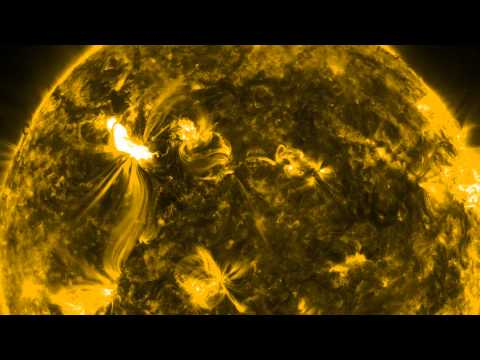

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo("4xKRBkBBEP0", start=9)

We still do not fully understand why a solar flare releases so much energy so fast, and what, exactly, the magnetic topology of the corona looks like during a flare. One commonly, though not universally, accepted theory is that ropes of magnetic field, called flux ropes, hang out in the chromosphere, or the layer between the solar surface and corona. These ropes twist up and release energy during a flare. If that's true, we should look at the chromosphere for clues. Let's grab an image showing a patch of the chromosphere where the flare takes place. First, let's import some modules:

In [2]:
import json, urllib, numpy as np, matplotlib.pylab as plt, matplotlib.ticker as mtick, requests
import sunpy.map
import drms
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from sunpy.cm import color_tables as ct
import sunpy.coordinates
from datetime import datetime as dt_obj
import matplotlib.dates as mdates
import matplotlib.colors as mcol
import matplotlib.patches as ptc
from matplotlib.dates import *
import math

Now, let's query the JSOC database, where all the SDO data are stored, using the JSON API to retrieve both keywords and the location of the AIA chromospheric image files. The first step is to establish a connection to JSOC. This can be done with the `drms.Client()` class. [Here is](https://drms.readthedocs.io/en/stable/index.html) more information on how to download SDO data using the drms module.

In [3]:
import drms
c = drms.Client()

The [astropy](http://docs.astropy.org/en/stable/io/fits/index.html) library's  `fits.open()` call downloads the data. 

In [4]:
keys_aia, segments = c.query('aia.lev1[2012.03.06_23:29:06_TAI/12s][?WAVELNTH=1600?]', key=drms.const.all, seg='image_lev1')
url_aia = 'http://jsoc.stanford.edu' + segments.image_lev1[0]   # add the jsoc.stanford.edu suffix to the segment name
chromosphere_image = fits.open(url_aia)                         # download the data
chromosphere_header = dict(keys_aia.iloc[0])
chromosphere_image.verify("fix")                                # We first have to use the astropy package to fix the FITS header as some of the AIA keywords have non-standard values.

We queried for a few keywords. We'll need these keywords later to coalign these data with others. For the AIA data, this is what they mean: 
* `T_REC` indicates the time the image was taken (technically the mid-point of the integration time),
* `CROTA2` indicates the rotation of the camera with respect to the fixed Sun in degrees,
* `CDELT1n` indicates the platescale of the instrument in arseconds per pixel,
* `CRPIXn` indicates the the location of the center of the Sun on the CCD in pixels, and 
* `CRVALn` indicates the same thing as `CRPIXn`, but in arcseconds. 

Here's an image of the chromosphere for the same flare as the YouTube video above. The [SunPy](http://docs.sunpy.org/en/stable/guide/plotting.html#peek) library's `peek()` function allows us to look at the data in the standard AIA color tables without much effort at all:

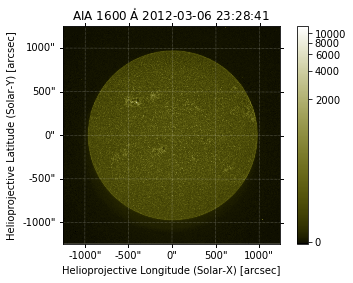

In [5]:
sunpy.map.Map(url_aia).peek()

The Helioseismic and Magnetic Imager (HMI), another instrument aboard SDO, takes images of the solar surface, or photosphere. Here's an image of the photosphere taken at the same time as the chromospheric image above. You can see that it is rotated 180 degrees with respect to the AIA image, which is why it is important for us to take the `CROTA2` value for each instrument into consideration when doing any array manipulation.

In [6]:
keys_hmi, segments = c.query('hmi.M_720s[2012.03.06_23:29:06_TAI]', key=drms.const.all, seg='magnetogram')
url_hmi = 'http://jsoc.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
photosphere_full_image = fits.getdata(url_hmi)                   # download the image data

In [7]:
header = dict(keys_hmi.iloc[0])

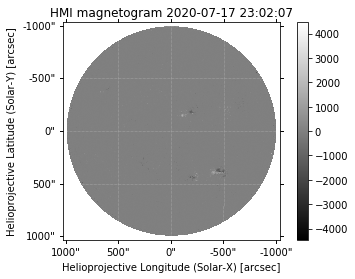

In [8]:
sunpy.map.Map(photosphere_full_image, header).peek()

The images above are 4096x4096 pixels, but binned down significantly. Let's zoom in on the active region. There's a particular type of SDO data called HMI Active Region Patches, or HARPs. These are bitmaps that identify automatically-detected active regions. Specifically, the bitmap array assigns a value to each pixel inside the bounding box, depending on whether it i) resides inside or outside the active region, and ii) corresponds to weak or strong line-of-sight magnetic field. This is what these patches look like for our selected `T_REC`:

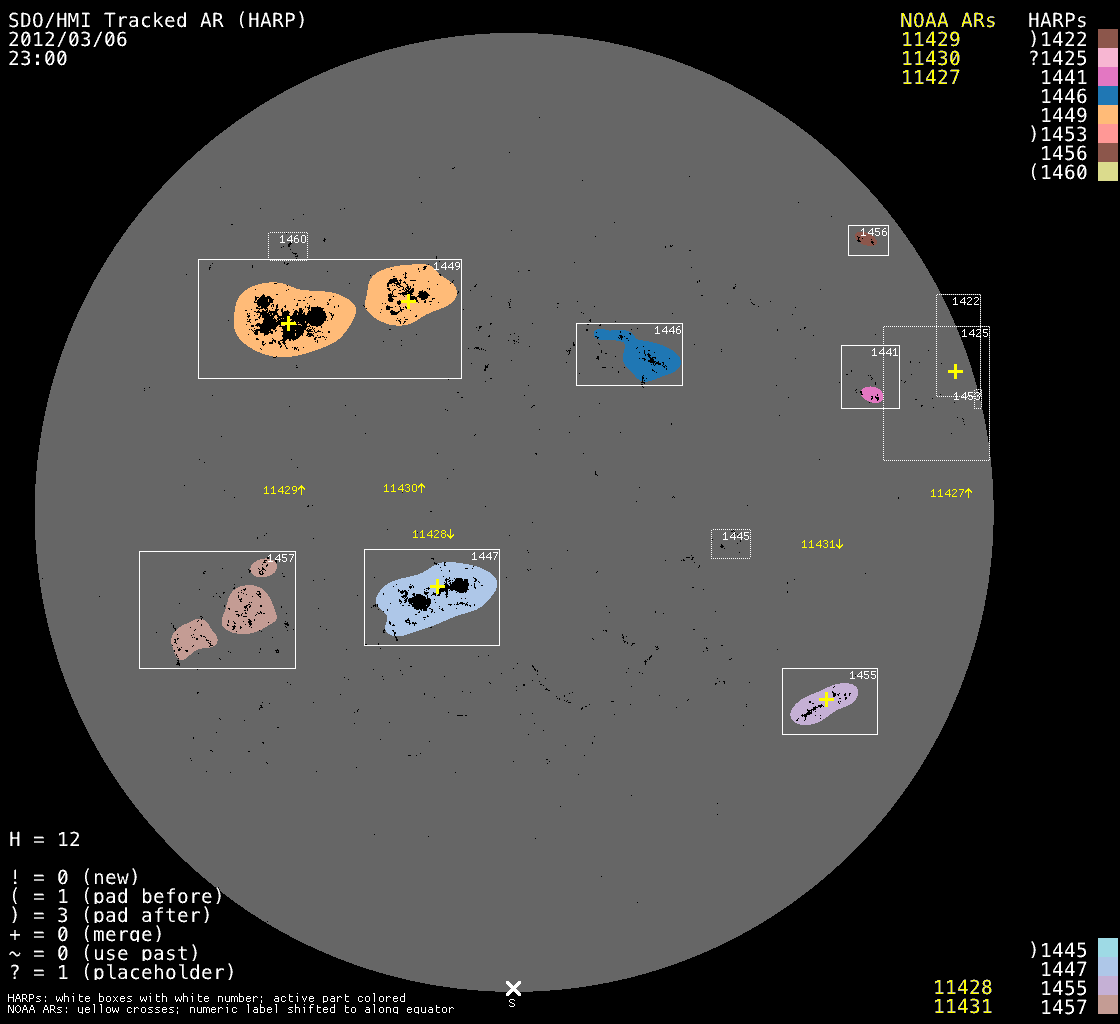

In [9]:
from IPython.display import Image
Image("http://jsoc.stanford.edu/doc/data/hmi/harp/harp_definitive/2012/03/06/harp.2012.03.06_23:00:00_TAI.png")

We use the HARP bounding box as a stencil to cut out patches of data from full-disk images. The full-disk SDO data use the standard World Coordinate System for solar images [(Thompson, 2006)](http://adsabs.harvard.edu/abs/2006A%26A...449..791T). The patch data, which we call [Space-weather HMI Active Region Patches](http://link.springer.com/article/10.1007%2Fs11207-014-0529-3) (or SHARPs), are available in either of two coordinate systems: one is effectively cut out directly from corrected full-disk images, which are in Helioprojective Cartesian CCD image coordinates, and the other is remapped from CCD coordinates to a Carrington Heliographic Cylindrical Equal-Area (CEA) projection centered on the patch. <br>

Now, we'll identify which AIA pixels are included inside each of these SHARP bounding boxes. First, let's go through an example for HARP number 1449 for our selected `T_REC` for the CCD case.

### Identifying which AIA pixels are within the CCD-coordinate SHARP bounding box

In addition to downloading the patch data, we also need some metadata. Here are the relevant keywords for the HMI SHARP Helioprojective Cartesian CCD image coordinate data:
* `CRPIXn` indicates the location, in pixels, of disk center with respect to the lower left-hand corner of the patch,
* `CROTA2` indicates the rotation of the camera with respect to the fixed Sun in degrees,
* `CDELTn` indicates the platescale of the instrument, in arcseconds per pixel, and
* `XDIM` and `YDIM` give the x and y-dimensions of the image, respectively, in pixels.

First, we query for CCD-coordinate SHARP data:

In [10]:
keys_ccd, segments = c.query('hmi.sharp_720s[1449][2012.03.06_23:29:06_TAI]', key=drms.const.all, seg='magnetogram')
url_ccd = 'http://jsoc.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
photosphere_image = fits.open(url_ccd)                           # download the data
XDIM_CCD = photosphere_image[1].data.shape[1]
YDIM_CCD = photosphere_image[1].data.shape[0]

Then we must make sure that the angle between the HMI camera and the fixed Sun is approximately zero; otherwise, we'll rotate the image to ensure this is so. 

In [11]:
if (keys_ccd.CROTA2[0] > 5.0):
    print("The HMI camera rotation angle is",keys_ccd.CROTA2[0],". Rotating HMI images.")
    photosphere_full_image = np.rot90(photosphere_full_image,2)
    photosphere_image[1].data = np.rot90(photosphere_image[1].data,2)

The HMI camera rotation angle is 180.082581 . Rotating HMI images.


Now we can plot HARP number 1449 at this `T_REC` in CCD coordinates (using the [SunPy color table](http://docs.sunpy.org/en/stable/_modules/sunpy/cm/cm.html) for SDO images):

The dimensions of this image are 480 by 1056 pixels.


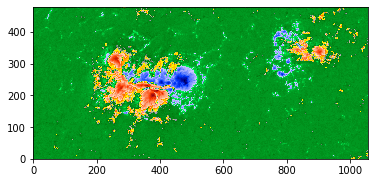

In [12]:
hmimag = plt.get_cmap('hmimag')
plt.imshow(photosphere_image[1].data,cmap=hmimag,origin='lower')
print('The dimensions of this image are',photosphere_image[1].data.shape[0],'by',photosphere_image[1].data.shape[1],'pixels.')

We can identify this area on the full-disk photospheric image in CCD coordinates for a sanity check. First, we identify the center of the disk in the full-disk image and its deviation from the center of the array: 

In [13]:
delta_disk_center_x = (2048.-keys_hmi.CRPIX1)
delta_disk_center_y = (2048.-keys_hmi.CRPIX2)

Now, we can identify the coordinates of both the lower left-hand corner and upper right-hand corner of the bounding box:

In [14]:
# lower left-hand corner
x1 = (2048. + delta_disk_center_x + keys_ccd.CRPIX1[0] - XDIM_CCD)
y1 = (2048. + delta_disk_center_y + keys_ccd.CRPIX2[0] - YDIM_CCD)  

# upper right-hand corner
x2 = (2048. + delta_disk_center_x + keys_ccd.CRPIX1[0])
y2 = (2048. + delta_disk_center_y + keys_ccd.CRPIX2[0])

Finally, we can plot the two coordinates and a bounding box connecting them:

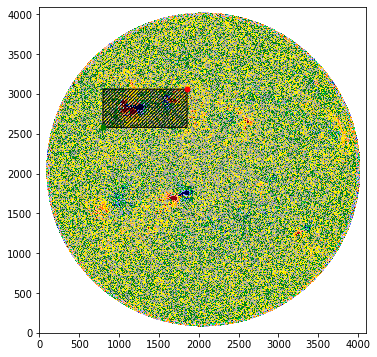

In [15]:
fig, ax = plt.subplots(1,1)
plt.imshow(photosphere_full_image,cmap=hmimag,origin='lower',vmax=300,vmin=-300,extent=[0,4096,0,4096])

# draw a box using matplotlib.patches.Rectangle
ax.add_patch(ptc.Rectangle((x1, y1), XDIM_CCD, YDIM_CCD, hatch='///////', fill=False, snap=False))

# plot a green dot at the lower left-hand corner
plt.plot(x1, y1, 'g.', markersize=10.0)

# plot a red dot at the upper right-hand corner
plt.plot(x2, y2, 'r.', markersize=10.0)
fig.set_size_inches(6,6)

If we are interested in cutting a SHARP-sized box out of AIA data, the first thing we can do is compute the ratio of the platescales. Since HMI and AIA are not observing in the same wavelength, the radius of the solar disk is different in both images and, as a result, the platescale is too:

In [16]:
ratio = (keys_ccd.CDELT1[0])/(keys_aia.CDELT1[0])
print("The ratio of the HMI:AIA platescales is",ratio,".")

The ratio of the HMI:AIA platescales is 0.8275571776235573 .


Now we can cut the same sized array out of the AIA data. We must make sure that the angle between the camera and the fixed Sun is approximately zero; otherwise, we'll rotate the image to ensure this is so. 

In [17]:
if (keys_aia.CROTA2[0] > 5.0):
    print("The AIA camera rotation angle is",keys_aia.CROTA2[0],". Rotating AIA image.")
    chromosphere_image[1].data = np.rot90(chromosphere_image[1].data,2)

In [18]:
y1 = int(2048. + delta_disk_center_y*(ratio) + keys_ccd.CRPIX2[0]*(ratio) - YDIM_CCD*(ratio))
y2 = int(2048. + delta_disk_center_y*(ratio) + keys_ccd.CRPIX2[0]*(ratio))
x1 = int(2048. + delta_disk_center_x*(ratio) + keys_ccd.CRPIX1[0]*(ratio) - XDIM_CCD*(ratio))
x2 = int(2048. + delta_disk_center_x*(ratio) + keys_ccd.CRPIX1[0]*(ratio))

In [19]:
subdata = chromosphere_image[1].data[y1:y2, x1:x2]

Now we can look at the patch of chromospheric data taken by the AIA instrument. Though it is not easy to see, the twisted S-shape feature may be the signature of a flux rope.

The dimensions of this image are 397 by 874 pixels.


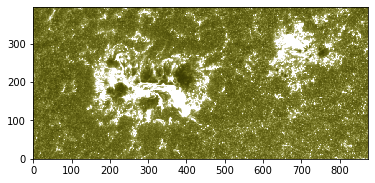

In [20]:
sdoaia1600 = plt.get_cmap('sdoaia1600')
plt.imshow(subdata,cmap=sdoaia1600,origin='lower',vmin=0,vmax=400)
print('The dimensions of this image are',subdata.shape[0],'by',subdata.shape[1],'pixels.')

You can see the chromospheric patch is a bit smaller, in both latitudinal and longitudinal extent, from the photospheric data taken by the HMI instrument. This is exactly what we expect since the solar radius is a bit smaller in the ultraviolet wavelengths taken by AIA versus the optical wavelengths observed by HMI.

### Identifying which AIA pixels are within the CEA-coordinate SHARP bounding box

Now we can go through the same exercise for CEA-coordinate SHARP data. The CEA data are useful for two reasons:
1. Each pixel is of an equal area, so derivatives or other such numerical computations are straightforward, and 
2. The space-weather keywords included in the SHARP metadata, which characterize the photospheric vector magnetic field, are computed using the CEA data; as such, computing a feature using a CEA-sized cutout of the AIA data allows for easy comparison between the space-weather keywords and any feature derived from the AIA data.

Here are the relevant keywords mean in the Carrington Heliographic Cylindrical Equal-Area coordinate system:
* `CRLT_OBS` indicates the Carrington latitude of the observer in degrees,
* `CDELTn` indicates the platescale of the image in degrees per pixel, which, per the definition of equal-area, is always constant (0.03 degrees per pixel),
* `CRVALn` indicates the longitude and latitude at the center of the patch, in degrees,
* `CRLN_OBS` indicates the Carrington longitude of the observer in degrees, and 
* `XDIM` and `YDIM` give the x and y-dimensions of the image, respectively, in pixels.

In [21]:
keys_cea, segments = c.query('hmi.sharp_cea_720s[1449][2012.03.06_23:29:06_TAI]', key=drms.const.all, seg='magnetogram')
url_cea = 'http://jsoc.stanford.edu' + segments.magnetogram[0]   # add the jsoc.stanford.edu suffix to the segment name
cea_image = fits.open(url_cea)                           # download the data
header = dict(keys_cea.iloc[0])
XDIM_CEA = cea_image[1].data.shape[1]
YDIM_CEA = cea_image[1].data.shape[0]

The dimensions of this CEA-projected image are 460 by 1167 pixels.


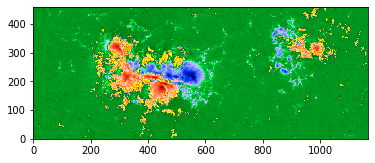

In [22]:
plt.imshow(cea_image[1].data,cmap=hmimag,origin='lower')
print('The dimensions of this CEA-projected image are',cea_image[1].data.shape[0],'by',cea_image[1].data.shape[1],'pixels.') 

And this is what the SHARP data look like in Carrington Heliographic coordinates, with a yellow X marking the center of the image.

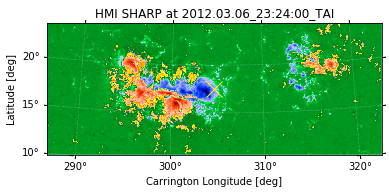

In [23]:
hmi_map = sunpy.map.Map(cea_image[1].data, header)
fig = plt.figure(figsize=(6,12))
ax = fig.add_subplot(2,1,1, projection=hmi_map)
hmi_map.plot(cmap=hmimag)
ax.set_title('HMI SHARP at '+str(keys_cea.T_REC[0]))

# Define the spatial center of HMI patch in latitude and longitude
xc = keys_cea.CRVAL1[0]*u.deg
yc = keys_cea.CRVAL2[0]*u.deg
coords = SkyCoord(xc, yc, frame=hmi_map.coordinate_frame)
p = ax.plot_coord(coords, 'x', color='yellow', markersize=16)

To map the CEA data to the AIA data, we follow the steps outlined in [Sun et al. (2014)](http://arxiv.org/pdf/1309.2392v1.pdf). First, we use the [SunPy coordinates](https://docs.sunpy.org/en/stable/code_ref/coordinates.html) module to convert the latitude and longitude at the center of the patch from the Heliographic Carrington coordinate system, which has units of degrees, to Helioprojective Cartesian coordinates, which has units of arcseconds. Second, we use the AIA platescale to convert arcseconds to AIA pixels. 

Let's plot three points, indicating the center, upper right-hand corner, and lower left-hand corner of the CEA bounding box on the AIA data:

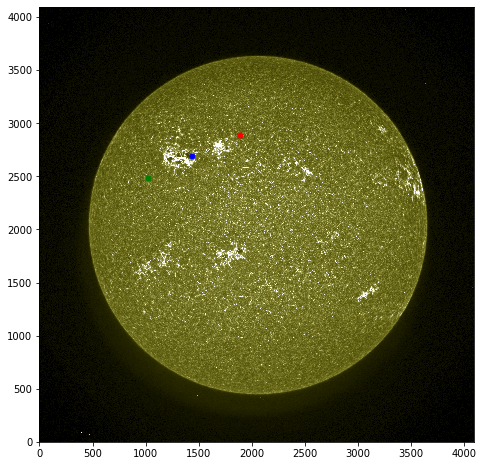

In [24]:
fig, ax = plt.subplots(1,1)
plt.imshow(chromosphere_image[1].data,origin='lower',cmap=sdoaia1600,vmin=0,vmax=400,extent=[0,4096,0,4096])

# [1] Create a Skycoord object in Heliographic Carrington coordinates to identify the spatial center of the CEA box
# --> the HMI keyword CRVALn is the center of the CEA box in Heliographic Carrington coordinates in degrees
# --> the frame argument looks at the HMI keyword CTYPEn keyword to construct a coordinate system
# --> the observer keyword looks at the HMI keywords CRLN_OBS and CRLT_OBS keywords to identify the location of the observer
frame_coord_center_hgc = SkyCoord(keys_cea.CRVAL1[0]*u.deg, keys_cea.CRVAL2[0]*u.deg, observer=hmi_map.observer_coordinate, frame=hmi_map.coordinate_frame)

# [2] Convert the spatial center of the CEA box from Heliographic Carrington to Helioprojective Cartesian coordinates
frame_coord_center_hpc = frame_coord_center_hgc.transform_to(frame="helioprojective")

# [3] Plot a blue dot at the spatial center of the CEA box on the AIA image
# --> the AIA keywords CRPIXn define the center of the AIA image in AIA pixels
# --> the AIA keywords CDELTn define the platescale of the AIA data in arcsec/AIA pixel
# --> thus (xc,yc) is the center of the CEA box in AIA pixels
x_center = ((frame_coord_center_hpc.Tx.value)/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0] 
y_center = ((frame_coord_center_hpc.Ty.value)/keys_aia.CDELT1[0]) + keys_aia.CRPIX2[0]
plt.plot(x_center, y_center, 'b.', markersize=10.0)

# [4] Create a Skycoord object in Heliographic Carrington coordinates to identify the lower left-hand corner of the CEA box
# --> mDIM_CEA are the dimensions of the CEA box in HMI pixels
# --> the HMI keywords CDELTn define the platescale of the CEA image in degrees/CEA pixel
# --> thus (x1,y1) is the lower left-hand corner of the CEA image in Carrington Heliographic coordinates (degrees)
x_lowerleft_hgc = keys_cea.CRVAL1[0] - 0.5*XDIM_CEA*keys_cea.CDELT1[0]
y_lowerleft_hgc = keys_cea.CRVAL2[0] - 0.5*YDIM_CEA*keys_cea.CDELT1[0]
frame_coord_lower_left_hgc = SkyCoord(x_lowerleft_hgc*u.deg, y_lowerleft_hgc*u.deg, observer=hmi_map.observer_coordinate, frame=hmi_map.coordinate_frame)

# [5] Convert the lower left-hand cornerof the CEA box from Heliographic Carrington to Helioprojective Cartesian coordinates
frame_coord_lower_left_hpc = frame_coord_lower_left_hgc.transform_to(frame="helioprojective")

# [6] Plot a green dot at the lower left-hand corner of the CEA box on the AIA image
x_lowerleft_hpc = ((frame_coord_lower_left_hpc.Tx.value)/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0]
y_lowerleft_hpc = ((frame_coord_lower_left_hpc.Ty.value)/keys_aia.CDELT1[0]) + keys_aia.CRPIX2[0]
plt.plot(x_lowerleft_hpc, y_lowerleft_hpc, 'g.', markersize=10.0)

# [7] Create a Skycoord object in Heliographic Carrington coordinates to identify the upper right-hand corner of the CEA box
x_upperright_hgc = keys_cea.CRVAL1[0] - 0.5*XDIM_CEA*keys_cea.CDELT1[0] + XDIM_CEA*keys_cea.CDELT1[0]
y_upperright_hgc = keys_cea.CRVAL2[0] - 0.5*YDIM_CEA*keys_cea.CDELT1[0] + YDIM_CEA*keys_cea.CDELT1[0]
frame_coord_upper_right_hgc = SkyCoord(x_upperright_hgc*u.deg, y_upperright_hgc*u.deg, observer=hmi_map.observer_coordinate, frame=hmi_map.coordinate_frame)

# [8] Convert the upper right-hand cornerof the CEA box from Heliographic Carrington to Helioprojective Cartesian coordinates
frame_coord_upper_right_hpc = frame_coord_upper_right_hgc.transform_to(frame="helioprojective")

# [7] Plot a red dot at the upper right-hand corner of the CEA box on the AIA image
x_upperright_hpc = ((frame_coord_upper_right_hpc.Tx.value)/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0]
y_upperright_hpc = ((frame_coord_upper_right_hpc.Ty.value)/keys_aia.CDELT1[0]) + keys_aia.CRPIX2[0]
plt.plot(x2, y2, 'r.', markersize=10.0)

fig.set_size_inches(8,8)

Naively, we might want to draw a bounding box connecting the green and red dots. But because the CEA data is projected, the bounding box is not a rectangular shape in CCD coordinates. Thus we will identify which AIA pixels lie within the CEA bounding box by using a mask.

First, populate the mask with NaNs:

In [25]:
aia_mask = np.full([4096,4096], np.nan)

Create a Skycoord object in Heliographic Carrington coordinates for all the points in the CEA box:

In [26]:
x_coord_single = [(keys_cea.CRVAL1[0] - 0.5*XDIM_CEA*keys_cea.CDELT1[0] + i*keys_cea.CDELT1[0]) for i in range(int(XDIM_CEA))]
y_coord_single = [(keys_cea.CRVAL2[0] - 0.5*YDIM_CEA*keys_cea.CDELT1[0] + j*keys_cea.CDELT1[0]) for j in range(int(YDIM_CEA))]

In [27]:
# Create pairs of (x, y) coordinates
x_coord_pair = []
y_coord_pair = []
for j in range(len(y_coord_single)):
    for i in range(len(x_coord_single)):
        y_coord_pair.append(y_coord_single[j])
        x_coord_pair.append(x_coord_single[i])

In [28]:
frame_coord_hg = SkyCoord(x_coord_pair*u.deg, y_coord_pair*u.deg, observer=hmi_map.observer_coordinate, frame=hmi_map.coordinate_frame)

Convert all the points in the CEA box from Heliographic Carrington to Helioprojective Cartesian coordinates:

In [29]:
HPC_out = frame_coord_hg.transform_to(frame="helioprojective")

Create a mask that identifies all the points in the CEA box on the AIA image:

In [30]:
x_aia = ((HPC_out.Tx.value/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0]).astype(int)
y_aia = ((HPC_out.Ty.value/keys_aia.CDELT1[0]) + keys_aia.CRPIX1[0]).astype(int)

In [31]:
aia_mask[y_aia,x_aia] = 1.0

This is what the mask looks like:

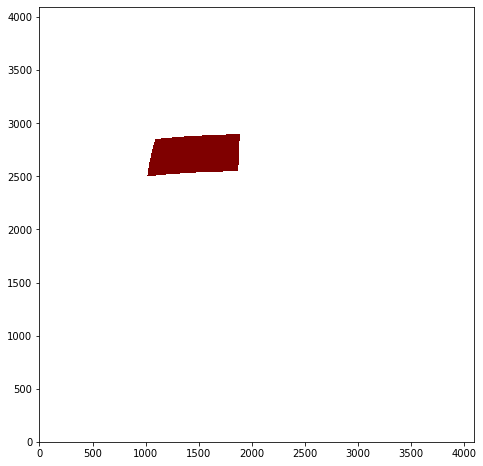

In [32]:
fig, ax = plt.subplots(1,1)
plt.imshow(aia_mask,origin='lower',vmin=0,vmax=1.0,cmap='seismic',extent=[0,4096,0,4096])
fig.set_size_inches(8,8)

And this is what the masked AIA image looks like:

In [33]:
aia_masked_data = chromosphere_image[1].data*aia_mask

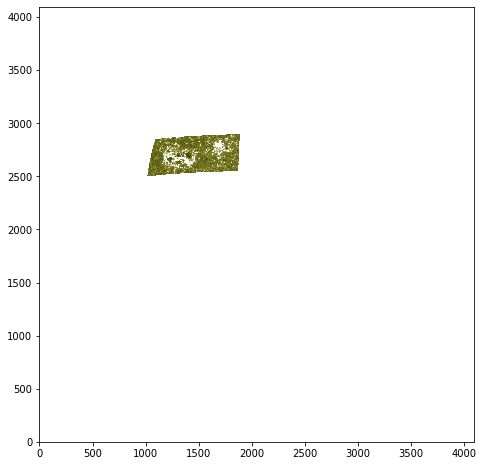

In [34]:
fig, ax = plt.subplots(1,1)
plt.imshow(aia_masked_data,origin='lower',vmin=0,vmax=400.0,cmap=sdoaia1600,extent=[0,4096,0,4096])
fig.set_size_inches(8,8)

Here's a closeup:

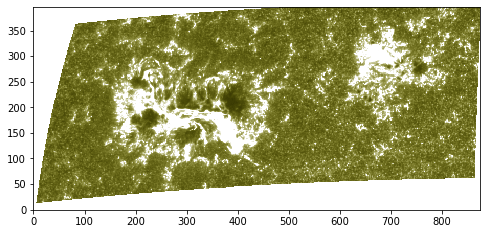

In [35]:
fig, ax = plt.subplots(1,1)
plt.imshow(aia_masked_data[int(y1):int(y2),int(x1):int(x2)],origin='lower',vmin=0,vmax=400.0,cmap=sdoaia1600)
fig.set_size_inches(8,8)

### Creating features using the AIA pixels within the CEA-coordinate SHARP bounding box

Now we can create a simple intensity threshold on the extracted chromospheric data, which better reveals the S-shape structure:

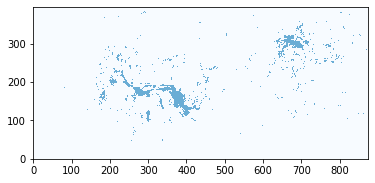

In [36]:
cea_data = aia_masked_data[int(y1):int(y2),int(x1):int(x2)]
threshold = cea_data > ((np.nanmean(cea_data))*2.5)
plt.imshow(threshold,cmap='Blues',origin='lower',vmin=0,vmax=2.)

Now we can create a new parameter, by summing up all of the pixels in the thresholded image:

In [37]:
print(np.sum(threshold))

9434


This parameter may be useful in predicting solar flares as it isolates the S-shape, which appears quite intense in the chromospheric data. Presumably, chromospheric data without an S-shape would have low values for this feature, whereas chromospheric data with an S-shape would have high values. As such, we can use a simple analysis like this to test if the presence of a flux rope is really associated with flaring active regions, assuming we've isolated it properly and that we accept that it is a flux rope in the first place. The Solar Dynamics Observatory's feature-finding team isolated S-shaped, or sigmoidal structures, in the data, as well as a host of other features known to be associated with solar flares. [Check out their results](http://link.springer.com/article/10.1007%2Fs11207-010-9697-y).